# **Model Training**

## **Data Preprocessing**

In [ ]:
# importing all necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import os
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
import warnings
from dotenv import load_dotenv

load_dotenv()
warnings.filterwarnings('ignore')

In [3]:
# reading data
main_df = pd.read_csv('data.csv')
main_df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [4]:
main_df.shape

(381109, 12)

In [5]:
main_df['Response'].value_counts()

Response
0    334399
1     46710
Name: count, dtype: int64

In [6]:
# taking 20% of data for experimentation
df = main_df.iloc[:int(0.2*main_df.shape[0])]

In [7]:
# shape of experimentation data 
df.shape

(76221, 12)

In [8]:
df['Response'].value_counts()

Response
0    66789
1     9432
Name: count, dtype: int64

In [9]:
# info of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76221 entries, 0 to 76220
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    76221 non-null  int64  
 1   Gender                76221 non-null  object 
 2   Age                   76221 non-null  int64  
 3   Driving_License       76221 non-null  int64  
 4   Region_Code           76221 non-null  float64
 5   Previously_Insured    76221 non-null  int64  
 6   Vehicle_Age           76221 non-null  object 
 7   Vehicle_Damage        76221 non-null  object 
 8   Annual_Premium        76221 non-null  float64
 9   Policy_Sales_Channel  76221 non-null  float64
 10  Vintage               76221 non-null  int64  
 11  Response              76221 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 7.0+ MB


In [10]:
# removing unwanted columns
columns_to_remove = ['id', 'Driving_License']
df.drop(columns=columns_to_remove, inplace=True)

In [11]:
# unique values in region code
print("There are", df['Region_Code'].nunique(), "unique values of region code")

There are 53 unique values of region code


In [12]:
# reducing categories in region code column 
region_counts = df['Region_Code'].value_counts()
df['Region_Code'] = [i if region_counts[i] >= 6280 else 1.0 for i in df['Region_Code']]

In [13]:
# checkin unique values in Region_Code column
df['Region_Code'].unique()

array([28.,  1.,  8.])

In [14]:
# changing datatype to str
df['Region_Code'] = df['Region_Code'].astype(str)

In [15]:
# reducing categories in region code column
policy_sales_channel_count = df['Policy_Sales_Channel'].value_counts()
df['Policy_Sales_Channel'] = [i if policy_sales_channel_count[i] >= 1360 else 1.0 for i in df['Policy_Sales_Channel']]

In [16]:
# checking unique values in Policy_Sales_Channel column
df['Policy_Sales_Channel'].unique()

array([ 26., 152., 160., 124.,   1., 156., 122.])

In [17]:
# changing datatype to str
df['Policy_Sales_Channel'] =df['Policy_Sales_Channel'].astype(str)

In [18]:
# encoding vehicle age column
df['Vehicle_Age'] = df['Vehicle_Age'].map({'< 1 Year':0, '1-2 Year':1, '> 2 Years':2}).astype(int)

In [19]:
# head of dataset
df.head()

,Gender,Age,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,44,28.0,0,2,Yes,40454.0,26.0,217,1
1,Male,76,1.0,0,1,No,33536.0,26.0,183,0
2,Male,47,28.0,0,2,Yes,38294.0,26.0,27,1
3,Male,21,1.0,1,0,No,28619.0,152.0,203,0
4,Female,29,1.0,1,0,No,27496.0,152.0,39,0


In [20]:
# splitting data into X and y
X = df.drop(columns='Response')
y = df['Response']

In [21]:
X.shape

(76221, 9)

In [22]:
# splitting data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [23]:
# capping values with maximum values (removing outliers)
X_train['Annual_Premium'] = [i if i < 61000 else 61000 for i in X_train['Annual_Premium']]

In [24]:
ohe_columns = ['Region_Code', 'Policy_Sales_Channel', 'Vehicle_Damage', 'Gender']
mm_columns = ['Age', 'Annual_Premium', 'Vintage', 'Vehicle_Age']

one_hot_encoder = OneHotEncoder(sparse_output=False)
min_max_scaler = MinMaxScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ("OneHotEncoder", one_hot_encoder, ohe_columns),
        ("MinMaxScaler", min_max_scaler, mm_columns)
    ],
    remainder='passthrough'  
)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [25]:
# random under sampling for balancing dataset
nn_under_sampler = RepeatedEditedNearestNeighbours(n_neighbors=4)
X_resampled, y_resampled = nn_under_sampler.fit_resample(X_train, y_train)
X_test_resampled, y_test_resampled = nn_under_sampler.fit_resample(X_test, y_test)

In [26]:
# printing shape of data
print("Shape of data before resampling:",X_train.shape)
print("Shape of data after resampling:",X_resampled.shape)
y_resampled.value_counts()

Shape of data before resampling: (57165, 19)
Shape of data after resampling: (39209, 19)


Response
0    32034
1     7175
Name: count, dtype: int64

In [27]:
X_resampled

array([[1.        , 0.        , 0.        , ..., 0.07612457, 0.        ,
        1.        ],
       [1.        , 0.        , 0.        , ..., 0.39792388, 0.        ,
        1.        ],
       [0.        , 1.        , 0.        , ..., 0.69550173, 0.5       ,
        0.        ],
       ...,
       [1.        , 0.        , 0.        , ..., 0.11072664, 0.5       ,
        0.        ],
       [1.        , 0.        , 0.        , ..., 0.1384083 , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.22145329, 0.5       ,
        0.        ]], shape=(39209, 19))

In [ ]:
# importing all ml models for classifications
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV

In [31]:
# Set MLflow tracking URI to your DAGsHub MLflow server
mlflow.set_tracking_uri("https://dagshub.com/yashmasane68/InsurePredict-Customer-Conversion-Insights.mlflow")
mlflow.set_experiment("Model Comparison Experiments")

# Define models
models = {
    'Logistic Regressor': LogisticRegression(),
    'Knearest Neighbour Classifier': KNeighborsClassifier(),
    'Decision Tree Classifier': DecisionTreeClassifier(),
    'Random Forest Classifier': RandomForestClassifier(),
    'Gradient Boosting Classifier': GradientBoostingClassifier(),
    'Support Vector Classifier': SVC(),
    'Adaboost Classifier': AdaBoostClassifier(),
    'xgb Classifier': XGBClassifier(),
    'catboost Classifier': CatBoostClassifier(verbose=0)
}

# To store best model
best_model = None
best_accuracy = 0
best_model_name = ""
best_model_obj = None

models_name = []
acc_score = [] 
precision = [] 
recall = []

# Loop through models
for model_name, model in models.items():
    with mlflow.start_run(run_name=model_name):
        print(f"\nTraining and evaluating: {model_name}")
        model.fit(X_resampled, y_resampled)
        y_pred = model.predict(X_test_resampled)

        # Metrics
        accuracy = round(accuracy_score(y_test_resampled, y_pred), 4)
        prec = round(precision_score(y_test_resampled, y_pred), 4)
        rec = round(recall_score(y_test_resampled, y_pred), 4)
        report = classification_report(y_test_resampled, y_pred, output_dict=True)

        models_name.append(model_name)
        acc_score.append(accuracy)
        precision.append(prec)
        recall.append(rec)

        # Log params (can log hyperparameters if customized)
        mlflow.log_param("model_name", model_name)

        # Log metrics
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", prec)
        mlflow.log_metric("recall", rec)

        # Confusion matrix plot
        cm = confusion_matrix(y_test_resampled, y_pred)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f"Confusion Matrix: {model_name}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.tight_layout()
        cm_path = f"confusion_matrix_{model_name}.png"
        plt.savefig(cm_path)
        mlflow.log_artifact(cm_path)
        plt.close()

        # Log classification report as txt
        report_path = f"classification_report_{model_name}.txt"
        with open(report_path, "w") as f:
            f.write(classification_report(y_test_resampled, y_pred))
        mlflow.log_artifact(report_path)

        # Log model itself
        mlflow.sklearn.log_model(model, artifact_path="model")

        # Track best model
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model_name = model_name
            best_model_obj = model

        # Clean up local artifact files
        os.remove(cm_path)
        os.remove(report_path)

print(f"\nBest model: {best_model_name} with accuracy: {best_accuracy}")

# Register the best model
with mlflow.start_run(run_name="Best_Model_Registration") as run:
    mlflow.sklearn.log_model(best_model_obj, artifact_path="best_model", registered_model_name="BestInsuranceClassifier")
    mlflow.log_metric("best_accuracy", best_accuracy)
    mlflow.log_param("best_model_name", best_model_name)

2025/08/07 11:00:38 INFO mlflow.tracking.fluent: Experiment with name 'Model Comparison Experiments' does not exist. Creating a new experiment.



Training and evaluating: Logistic Regressor


2025/08/07 11:00:52 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/08/07 11:00:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Logistic Regressor at: https://dagshub.com/yashmasane68/InsurePredict-Customer-Conversion-Insights.mlflow/#/experiments/1/runs/74200a05d8004655ba3ce9d3d7b4984a
🧪 View experiment at: https://dagshub.com/yashmasane68/InsurePredict-Customer-Conversion-Insights.mlflow/#/experiments/1

Training and evaluating: Knearest Neighbour Classifier


2025/08/07 11:01:05 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/08/07 11:01:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Knearest Neighbour Classifier at: https://dagshub.com/yashmasane68/InsurePredict-Customer-Conversion-Insights.mlflow/#/experiments/1/runs/da46372a665c488a83ffda4c9d44725d
🧪 View experiment at: https://dagshub.com/yashmasane68/InsurePredict-Customer-Conversion-Insights.mlflow/#/experiments/1

Training and evaluating: Decision Tree Classifier


2025/08/07 11:01:21 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/08/07 11:01:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Decision Tree Classifier at: https://dagshub.com/yashmasane68/InsurePredict-Customer-Conversion-Insights.mlflow/#/experiments/1/runs/f83dc3c6f6a741038274c99ee9214d5e
🧪 View experiment at: https://dagshub.com/yashmasane68/InsurePredict-Customer-Conversion-Insights.mlflow/#/experiments/1

Training and evaluating: Random Forest Classifier


2025/08/07 11:01:37 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/08/07 11:01:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Random Forest Classifier at: https://dagshub.com/yashmasane68/InsurePredict-Customer-Conversion-Insights.mlflow/#/experiments/1/runs/ae87326e1bc14b34ac2d8c6712663ca1
🧪 View experiment at: https://dagshub.com/yashmasane68/InsurePredict-Customer-Conversion-Insights.mlflow/#/experiments/1

Training and evaluating: Gradient Boosting Classifier


2025/08/07 11:02:08 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/08/07 11:02:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Gradient Boosting Classifier at: https://dagshub.com/yashmasane68/InsurePredict-Customer-Conversion-Insights.mlflow/#/experiments/1/runs/421720e14401459ba16b558d13f0d01d
🧪 View experiment at: https://dagshub.com/yashmasane68/InsurePredict-Customer-Conversion-Insights.mlflow/#/experiments/1

Training and evaluating: Support Vector Classifier


2025/08/07 11:02:30 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/08/07 11:02:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Support Vector Classifier at: https://dagshub.com/yashmasane68/InsurePredict-Customer-Conversion-Insights.mlflow/#/experiments/1/runs/a999a4d870204173ae71f9eb35f92a96
🧪 View experiment at: https://dagshub.com/yashmasane68/InsurePredict-Customer-Conversion-Insights.mlflow/#/experiments/1

Training and evaluating: Adaboost Classifier


2025/08/07 11:02:43 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/08/07 11:02:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Adaboost Classifier at: https://dagshub.com/yashmasane68/InsurePredict-Customer-Conversion-Insights.mlflow/#/experiments/1/runs/20e0cf3d89ac4b86bba324ecb81cc589
🧪 View experiment at: https://dagshub.com/yashmasane68/InsurePredict-Customer-Conversion-Insights.mlflow/#/experiments/1

Training and evaluating: xgb Classifier


2025/08/07 11:02:55 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/08/07 11:02:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run xgb Classifier at: https://dagshub.com/yashmasane68/InsurePredict-Customer-Conversion-Insights.mlflow/#/experiments/1/runs/d6dc37d46c2e4c8fa304d921d9b44214
🧪 View experiment at: https://dagshub.com/yashmasane68/InsurePredict-Customer-Conversion-Insights.mlflow/#/experiments/1

Training and evaluating: catboost Classifier


2025/08/07 11:03:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/08/07 11:03:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run catboost Classifier at: https://dagshub.com/yashmasane68/InsurePredict-Customer-Conversion-Insights.mlflow/#/experiments/1/runs/0a6e9197e80b475386cd2223084fe04a
🧪 View experiment at: https://dagshub.com/yashmasane68/InsurePredict-Customer-Conversion-Insights.mlflow/#/experiments/1

Best model: Gradient Boosting Classifier with accuracy: 0.9584


2025/08/07 11:03:22 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/08/07 11:03:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'BestInsuranceClassifier' already exists. Creating a new version of this model...
2025/08/07 11:03:27 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: BestInsuranceClassifier, version 2
Created version '2' of model 'BestInsuranceClassifier'.


🏃 View run Best_Model_Registration at: https://dagshub.com/yashmasane68/InsurePredict-Customer-Conversion-Insights.mlflow/#/experiments/1/runs/fad5d954bfad422f8385f03d904cae2c
🧪 View experiment at: https://dagshub.com/yashmasane68/InsurePredict-Customer-Conversion-Insights.mlflow/#/experiments/1


In [32]:
# creating dataframe for metrics
metrics_df = pd.DataFrame({'Model Names':models_name, 'Accuracy':acc_score, 
                           'Precision': precision, 'Recall':recall})

metrics_df.sort_values(by='Accuracy', ascending=False)

,Model Names,Accuracy,Precision,Recall
4,Gradient Boosting Classifier,0.9584,0.8812,0.8808
0,Logistic Regressor,0.9563,0.8744,0.8759
8,catboost Classifier,0.9556,0.8651,0.8839
5,Support Vector Classifier,0.9547,0.8604,0.8848
7,xgb Classifier,0.9547,0.8586,0.8875
6,Adaboost Classifier,0.9537,0.8666,0.8693
3,Random Forest Classifier,0.9506,0.8342,0.8959
1,Knearest Neighbour Classifier,0.9454,0.8314,0.8631
2,Decision Tree Classifier,0.9330,0.7773,0.8644


Gradient boosting classifier shows good balance between precision and recall and has low training and inference time so we will go with Gradient Boosting Classifier

2025/08/07 11:03:32 INFO mlflow.tracking.fluent: Experiment with name 'Best Model Experiment' does not exist. Creating a new experiment.


Fitting 5 folds for each of 20 candidates, totalling 100 fits
              precision    recall  f1-score   support

           0       0.98      0.70      0.81     16799
           1       0.28      0.88      0.43      2257

    accuracy                           0.72     19056
   macro avg       0.63      0.79      0.62     19056
weighted avg       0.90      0.72      0.77     19056



2025/08/07 11:06:00 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/08/07 11:06:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run trusting-stork-274 at: https://dagshub.com/yashmasane68/InsurePredict-Customer-Conversion-Insights.mlflow/#/experiments/2/runs/325573305aee4f23957fb1431fae8f9e
🧪 View experiment at: https://dagshub.com/yashmasane68/InsurePredict-Customer-Conversion-Insights.mlflow/#/experiments/2


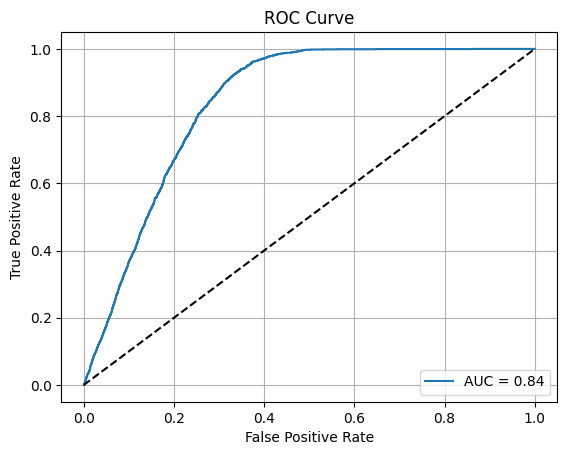

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score

# Set MLflow tracking URI and experiment
mlflow.set_tracking_uri("https://dagshub.com/yashmasane68/InsurePredict-Customer-Conversion-Insights.mlflow")
mlflow.set_experiment("Best Model Experiment")

# Define the classifier
gbc = GradientBoostingClassifier()

# Define the hyperparameter grid
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 1.0],
}

# Perform randomized search with cross-validation
random_search = RandomizedSearchCV(
    estimator=gbc,
    param_distributions=param_dist,
    n_iter=20,                # Number of different combinations to try
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Start MLflow run
with mlflow.start_run():
    # Fit the model
    random_search.fit(X_resampled, y_resampled)

    # Log all best parameters
    best_params = random_search.best_params_
    for param, value in best_params.items():
        mlflow.log_param(param, value)

    # Get the best model
    best_model = random_search.best_estimator_

    # Predict and evaluate on test data
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]  # Probability estimates for ROC AUC

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("roc_auc", auc)

    # Print classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    print(classification_report(y_test, y_pred))

    # Log classification metrics
    for label, scores in report.items():
        if isinstance(scores, dict):
            for metric_name, score in scores.items():
                mlflow.log_metric(f"{label}_{metric_name}", score)

    # Plot and log ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    
    # Save and log plot
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    signature = infer_signature(X_train, y_pred)
    # Log the model itself
    mlflow.sklearn.log_model(best_model, "gradient_boosting_model", signature=signature)


In [35]:
random_search.best_params_

{'subsample': 1.0,
 'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_depth': 5,
 'learning_rate': 0.2}